In [14]:
!pip uninstall numpy matplotlib -y
!pip install numpy matplotlib

Found existing installation: numpy 1.26.3
Uninstalling numpy-1.26.3:
^C
ERROR: Operation cancelled by user
  Using cached numpy-1.26.3-cp310-cp310-macosx_10_9_x86_64.whl (20.6 MB)

[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [3]:
def get_hparam_from_config(config, opt, hparam_name):
    if hparam_name == 'num_neurons':
        return config['num_neurons']
    elif hparam_name == 'adam_lr':
        opt_params = config['opt_params']
        if 'adam_lbfgs' in opt:
            return float(opt_params[opt_params.index('adam_lr') + 1])
        elif opt == 'adam':
            return float(opt_params[opt_params.index('lr') + 1])
        elif opt == 'lbfgs':
            return None

In [4]:
def get_best_min_key(performance_data, mode_val, combo_len):
    # For a fixed value of mode_val, get the key with the lowest minimum value
    # of the performance metric
    best_min_key = None
    best_min_val = np.inf
    for key, val in performance_data.items():
        min_val = np.min(val)
        if combo_len == 1:
            if key == mode_val and min_val < best_min_val:
                best_min_key = key
                best_min_val = min_val
        elif combo_len == 2:
            if key[0] == mode_val and min_val < best_min_val:
                best_min_key = key
                best_min_val = min_val

    return best_min_key

In [5]:
def get_best_performance(pde_name, pde_params, metric, opt, analysis_mode, other_hparams, extensions, entity_name):
    proj_name = f'{pde_name}_{extensions[opt]}'
    mode_name = analysis_mode['name']
    mode_values = analysis_mode['values']

    other_hparams_name = other_hparams['name']
    performance_data = {}

    combo_len = 1

    api = wandb.Api()
    for run in api.runs(f'{entity_name}/{proj_name}'):
        if run.state != 'finished':
            continue
        config = run.config
        if config['pde_params'] != pde_params:
            continue

        mode_value = get_hparam_from_config(config, opt, mode_name)
        other_hparam_value = get_hparam_from_config(config, opt, other_hparams_name)

        if other_hparam_value is None:
            combo = mode_value
        else:
            combo = (mode_value, other_hparam_value)
            combo_len = 2

        if combo not in performance_data:
            performance_data[combo] = []

        if combo in performance_data:
            if isinstance(run.summary[metric], (float, int)):
                performance_data[combo].append(run.summary[metric])
            else:
                performance_data[combo].append(np.inf) # If 'NaN', set to inf for computation purposes
    
    # For each mode value, get the key with the best min performance
    best_min_key = {mode_value: get_best_min_key(performance_data, mode_value, combo_len) for mode_value in mode_values}

    # For each mode value, get the best min performance using the best min key
    # Also get the median and max performance corresponding to the best min performance
    best_min_performance = {mode_value: np.min(performance_data[best_min_key[mode_value]]) for mode_value in mode_values}
    median_performance = {mode_value: np.median(performance_data[best_min_key[mode_value]]) for mode_value in mode_values}
    max_performance = {mode_value: np.max(performance_data[best_min_key[mode_value]]) for mode_value in mode_values}
    
    return best_min_performance, median_performance, max_performance

In [6]:
def get_best_performance_opts(pde_name, pde_params, metric, opts, analysis_mode, other_hparams, extensions, entity_name):
    opt_best_results = {}
    for opt in opts:
        opt_best_results[opt] = get_best_performance(pde_name, pde_params, metric, opt, analysis_mode, other_hparams, extensions, entity_name)
    return opt_best_results

In [7]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    elif pde_name == "reaction":
        return f'Reaction, $\\rho = {pde_params[1]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

In [8]:
def plot_best_median_performance_multi_pde(pdes, metrics, opts, analysis_mode, other_hparams, extensions, entity_name,
                                     opt_names, metric_names, opt_colors, font_size, folder_path,
                                       filename):
    mpl.rcParams.update({'font.size': font_size})

    nrows = len(metrics)
    ncols = len(pdes)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))  # Adjust figsize as needed

    mode_values = analysis_mode['values']
    mode_label = analysis_mode['label']

    custom_legend_optimizers = [mpl.lines.Line2D([0], [0], color=opt_colors[opt], linestyle='-', label=opt_names[opt]) for opt in opts]
    bar_width = 0.15  # Adjust as needed for the width of the bars

    for row, metric in enumerate(metrics):
        for col, (pde_name, pde_params) in enumerate(pdes):
            opt_best_results = get_best_performance_opts(pde_name, pde_params, metric, opts, analysis_mode, other_hparams, extensions, entity_name)
            
            ax = axs[row, col] if nrows > 1 and ncols > 1 else (axs[col] if nrows == 1 else axs[row])
            for i, opt in enumerate(opts):
                x_positions = np.arange(len(mode_values)) + i * bar_width
                median_values = [opt_best_results[opt][1][val] for val in mode_values]  # 1 for median
                min_values = [opt_best_results[opt][0][val] for val in mode_values]  # 0 for min
                max_values = [opt_best_results[opt][2][val] for val in mode_values]  # 2 for max
                error = [median_values[j] - min_values[j] for j in range(len(median_values))], \
                        [max_values[j] - median_values[j] for j in range(len(median_values))]

                ax.bar(x_positions, median_values, bar_width, label=f"{opt_names[opt]}", color=opt_colors[opt])
                ax.errorbar(x_positions, median_values, yerr=error, fmt='none', ecolor='black', capsize=3, alpha=0.25)

            ax.set_yscale('log')
            ax.set_ylabel(metric_names[metric])
            ax.set_xlabel(mode_label)
            ax.set_xticks(np.arange(len(mode_values)) + (len(opts) - 1) * bar_width / 2)
            ax.set_xticklabels(mode_values)
            ax.set_title(get_title(pde_name, pde_params))

    # Adjust the legend and layout
    fig.legend(custom_legend_optimizers, [h.get_label() for h in custom_legend_optimizers], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(opts))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Saving the figure
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    filename = filename + '_' + analysis_mode['name'] + '.pdf'
    fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
    plt.show()

In [9]:
entity_name = 'sketchy-opts'
extensions = {
    'adam': 'adam_final',
    'lbfgs': 'lbfgs_final',
    'adam_lbfgs': 'adam_lbfgs_final',
    'adam_lbfgs_11k': 'adam_lbfgs_final_11k',
    'adam_lbfgs_31k': 'adam_lbfgs_final_31k'
}
opt_names = {
    'adam': 'Adam',
    'lbfgs': 'L-BFGS',
    'adam_lbfgs': 'Adam + L-BFGS (1k)',
    'adam_lbfgs_11k': 'Adam + L-BFGS (11k)',
    'adam_lbfgs_31k': 'Adam + L-BFGS (31k)'
}
opt_colors = {
    'adam': 'tab:blue',
    'lbfgs': 'tab:orange',
    'adam_lbfgs': 'tab:green',
    'adam_lbfgs_11k': 'tab:red',
    'adam_lbfgs_31k': 'tab:purple'
}
metric_names = {
    'train/l2re': 'Training L2RE',
    'train/l1re': 'Training L1RE',
    'test/l2re': 'L2RE',
    'test/l1re': 'Test L1RE',
    'loss': 'Loss'
}

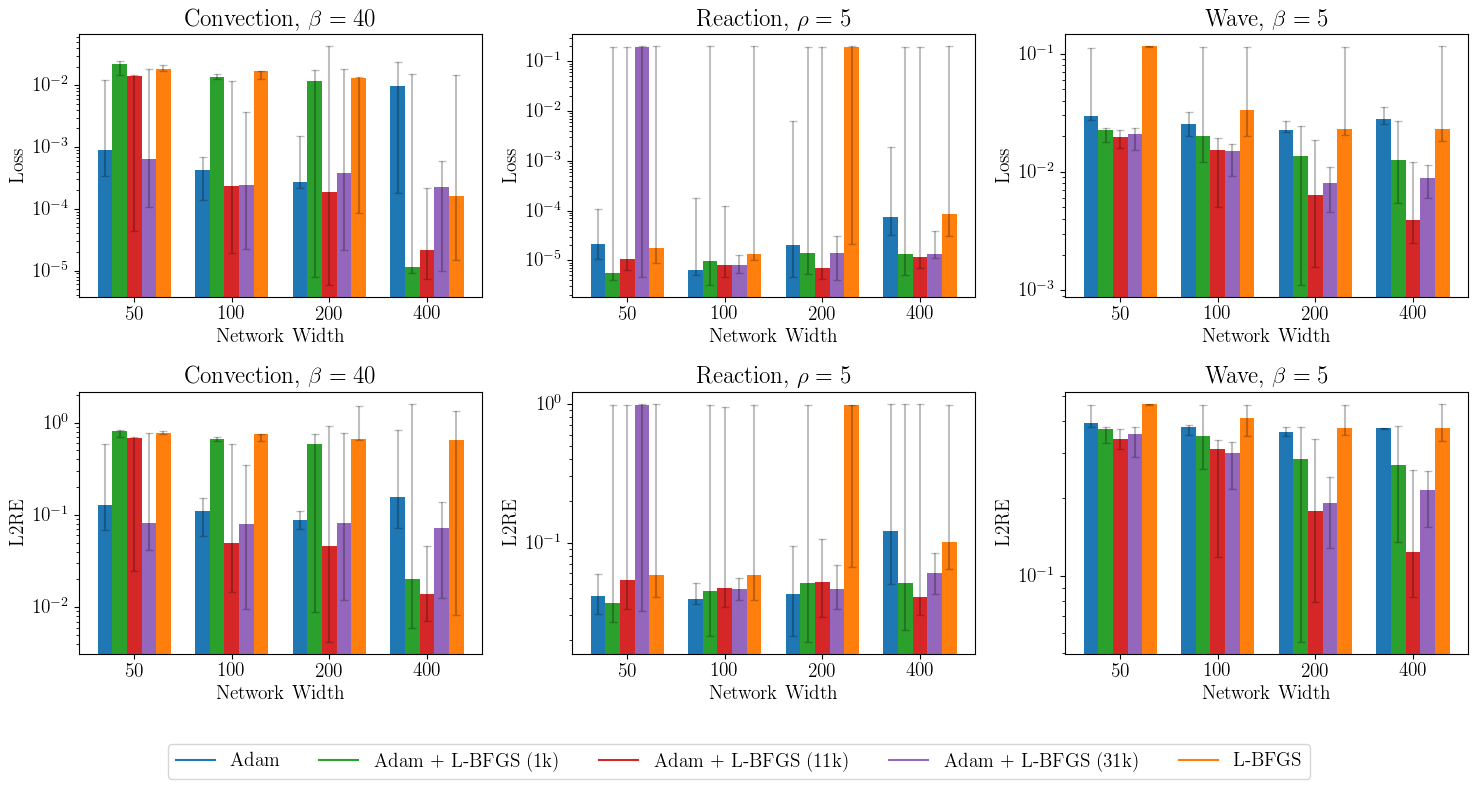

In [10]:
pdes = [('convection', ['beta', '40']), ('reaction', ['rho', '5']), ('wave', ['beta', '5'])]
metrics = ['loss', 'test/l2re']
opts = ['adam', 'adam_lbfgs', 'adam_lbfgs_11k', 'adam_lbfgs_31k', 'lbfgs']
analysis_mode_width = {
    'name': 'num_neurons',
    'values': [50, 100, 200, 400],
    'label': 'Network Width'
}
# opts = ['adam_lbfgs', 'adam_lbfgs_11k', 'adam_lbfgs_31k']
analysis_mode_adam_lr = {
    'name': 'adam_lr',
    'values': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'label': 'Learning Rate'
}

folder_path = 'opt_comparison_plots'
filename = 'loss_l2re'

# plot_best_performance_multi_pde(pdes, metrics, opts, analysis_mode_width, extensions, entity_name, opt_names, metric_names, opt_colors,
#                                 font_size=14, folder_path=folder_path, filename=filename)

plot_best_median_performance_multi_pde(pdes, metrics, opts, analysis_mode_width, analysis_mode_adam_lr, extensions, entity_name, opt_names, metric_names, opt_colors,
                                font_size=14, folder_path=folder_path, filename=filename)